<h1>Phase 4 Final Project Submission</h1>

<h3>Student Name: Jason Lombino</h3>
<hr>

<h1>Business Problem</h1>

<h1>Libraries</h1>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from skimage.segmentation import mark_boundaries
from lime import lime_image
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras import preprocessing
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras import applications
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

<h1>Data

In [2]:
train_path = 'chest_xray/train'
test_path = 'chest_xray/test'
val_path = 'chest_xray/val'

In [3]:
train_generator = preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=45,
    zoom_range=0.3
)

train_ds = train_generator.flow_from_directory(
    train_path,
    target_size=(256,256),
    class_mode='binary',
)

train_norm = len(os.listdir(train_path + '/NORMAL'))
train_sick = len(os.listdir(train_path + '/PNEUMONIA'))

Found 4175 images belonging to 2 classes.


In [4]:
val_generator = preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

val_ds = val_generator.flow_from_directory(
    val_path,
    target_size=(256,256),
    class_mode='binary',
    shuffle=False
)

val_norm = len(os.listdir(val_path + '/NORMAL'))
val_sick = len(os.listdir(val_path + '/PNEUMONIA'))

Found 1057 images belonging to 2 classes.


In [5]:
test_generator = preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_ds = test_generator.flow_from_directory(
    test_path,
    target_size=(256,256),
    class_mode='binary',
    shuffle=False
)

test_norm = len(os.listdir(test_path + '/NORMAL'))
test_sick = len(os.listdir(test_path + '/PNEUMONIA'))

Found 624 images belonging to 2 classes.


<h1>Data Visualizations

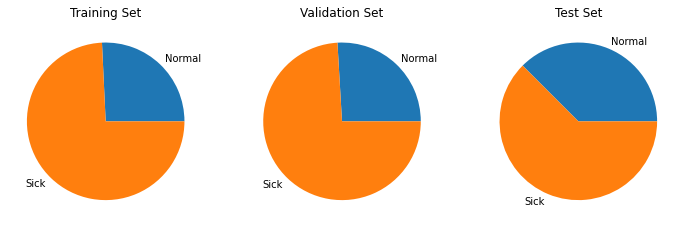

In [6]:
data_fig, data_ax = plt.subplots(1,3,figsize=(12,4))
data_ax[0].pie([train_norm,train_sick],labels=['Normal','Sick']);
data_ax[0].set_title('Training Set');

data_ax[1].pie([val_norm,val_sick],labels=['Normal','Sick']);
data_ax[1].set_title('Validation Set');

data_ax[2].pie([test_norm,test_sick],labels=['Normal','Sick']);
data_ax[2].set_title('Test Set');

data_fig.set_facecolor('#FFFFFF')

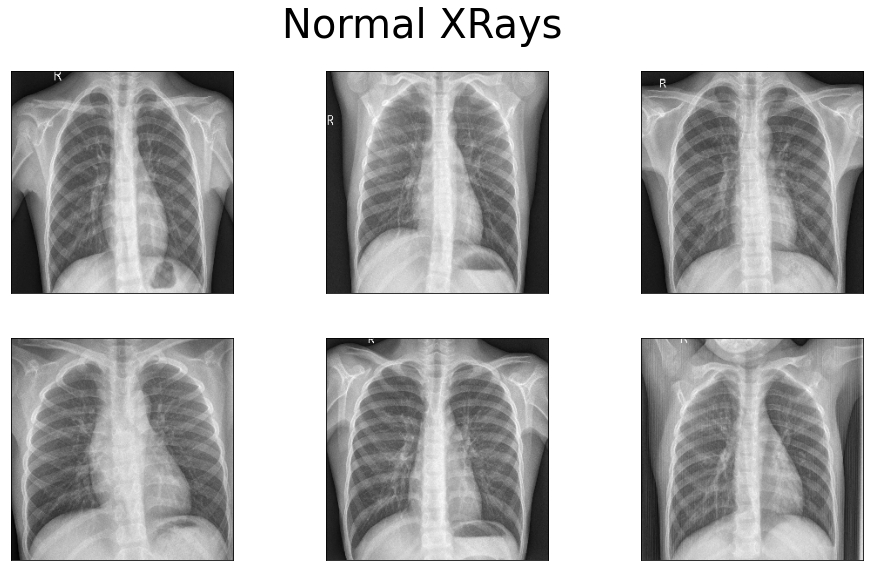

In [7]:
normal_images = []
for image in test_ds[0][0][:6]:
    normal_images.append(image)

normal_fig,normal_ax = plt.subplots(2,3,figsize=(16,9))
for idx,image in enumerate(normal_images[:6]):
        active_axis = normal_ax[idx//3][idx%3]
        active_axis.imshow(image)
        active_axis.set_xticks([])
        active_axis.set_yticks([])
normal_fig.set_facecolor('#FFFFFF')
normal_fig.suptitle('Normal XRays', fontsize=40);

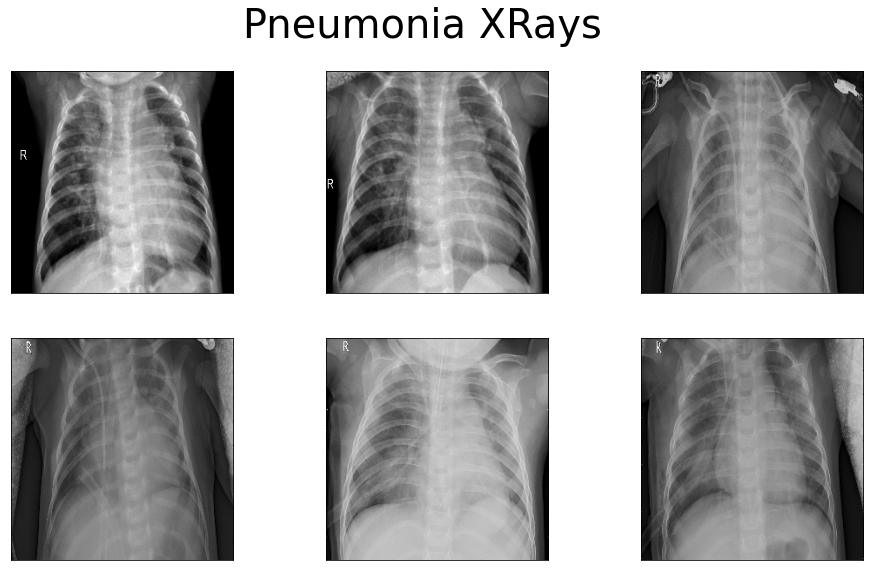

In [8]:
sick_images = []
for image in test_ds[len(test_ds)-1][0][:6]:
    sick_images.append(image)

sick_fig,sick_ax = plt.subplots(2,3,figsize=(16,9))
for idx,image in enumerate(sick_images[:6]):
        active_axis = sick_ax[idx//3][idx%3]
        active_axis.imshow(image)
        active_axis.set_xticks([])
        active_axis.set_yticks([])
sick_fig.set_facecolor('#FFFFFF')
sick_fig.suptitle('Pneumonia XRays', fontsize=40);

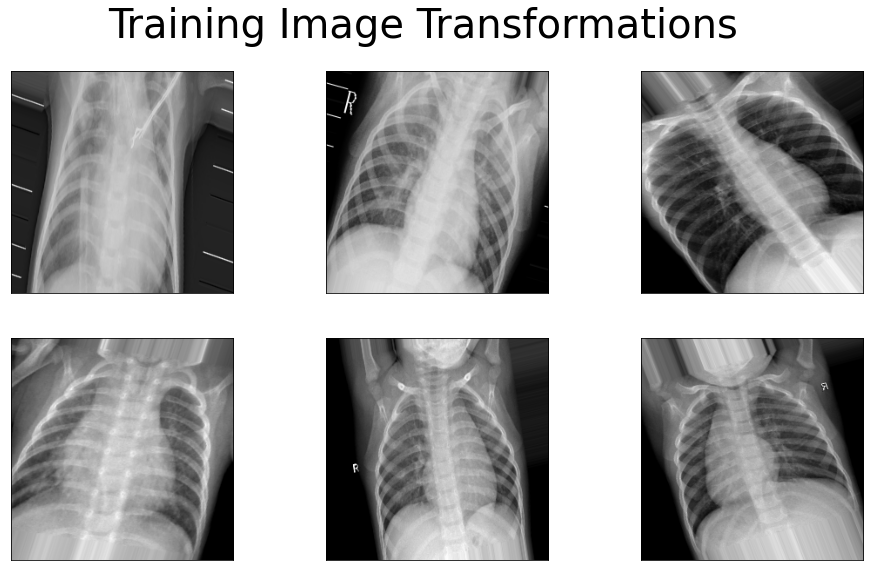

In [9]:
train_prep = train_ds[0][0][:6]

train_fig,train_ax = plt.subplots(2,3,figsize=(16,9))
for idx,image in enumerate(train_prep[:6]):
        active_axis = train_ax[idx//3][idx%3]
        active_axis.imshow(image)
        active_axis.set_xticks([])
        active_axis.set_yticks([])
train_fig.set_facecolor('#FFFFFF')
train_fig.suptitle('Training Image Transformations', fontsize=40);

<h1>Modeling</h1>

Various models results

| Model Name                                     | % Train Accuracy | % Val Accuracy | 
|------------------------------------------------|------------------|----------------|
| * Basic CNN                                      | 98.8             | 96.7           | 
| Basic CNN Image Preprocessing                  | 93.5             | 91.2           | 
| Larger CNN                                     | 93.5             | 94.0           | 
| Larger CNN tanh Activation                     | 74.3             | 74.1           | 
| Larger CNN Dropout                             | 93.3             | 94.0           | 
| Larger CNN Larger Stride                       | 95.3             | 93.4           | 
| Larger CNN Double Convolutional Layers         | 95.5             | 94.0           | 
| Even Larger CNN                                | 94.8             | 94.5           | 
| Transfer Learning Xception                     | 96.6             | 94.0           | 
| Transfer Learning VGG16                        | 95.0             | 95.7           | 
| Transfer Learning VGG16 Decaying Learning Rate | 94.7             | 94.2           |

<h1>Second Best Model (Even Larger CNN)</h1>

In [10]:
nt_model = models.Sequential()

nt_model.add(layers.Conv2D(32, (1, 1), activation='relu',padding='same',
                        input_shape=(256, 256, 3)))     
nt_model.add(layers.Conv2D(32, (1, 1), activation='relu',padding='same'))                
nt_model.add(layers.MaxPooling2D((2, 2)))

nt_model.add(layers.Conv2D(64, (1, 1), activation='relu',padding='same'))
nt_model.add(layers.Conv2D(64, (1, 1), activation='relu',padding='same'))
nt_model.add(layers.MaxPooling2D((2, 2)))

nt_model.add(layers.Conv2D(128, (1, 1), activation='relu',padding='same'))
nt_model.add(layers.Conv2D(128, (1, 1), activation='relu',padding='same'))
nt_model.add(layers.MaxPooling2D((2, 2)))

nt_model.add(layers.Conv2D(256, (1, 1), activation='relu',padding='same'))
nt_model.add(layers.Conv2D(256, (1, 1), activation='relu',padding='same'))
nt_model.add(layers.MaxPooling2D((2, 2)))

nt_model.add(layers.Flatten())
nt_model.add(layers.Dense(512, activation='relu'))
nt_model.add(layers.Dropout(rate=0.25))
nt_model.add(layers.Dense(512, activation='relu'))
nt_model.add(layers.Dropout(rate=0.25))
nt_model.add(layers.Dense(256, activation='relu'))
nt_model.add(layers.Dropout(rate=0.25))
nt_model.add(layers.Dense(128, activation='relu'))
nt_model.add(layers.Dropout(rate=0.25))
nt_model.add(layers.Dense(64, activation='relu'))
nt_model.add(layers.Dropout(rate=0.25))
nt_model.add(layers.Dense(32, activation='relu'))
nt_model.add(layers.Dense(1, activation='sigmoid'))

In [11]:
nt_checkpoint = callbacks.ModelCheckpoint(
    monitor='val_loss',
    filepath='save_data/nt_model.hdf5',
    save_best_only=True,
    verbose=0
)

nt_callbacks = [nt_checkpoint]

use_metrics = [metrics.BinaryAccuracy(),\
                metrics.Precision(),\
                metrics.Recall()]

In [12]:
nt_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(),
    metrics=[use_metrics]
)

print(nt_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      128       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      1056      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      2112      
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      4160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                    

In [13]:
with tf.device('/GPU:0'):
    nt_history = nt_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=5,
        callbacks=nt_callbacks
    )

nt_model.load_weights('save_data/nt_model.hdf5')

Epoch 1/5
131/131 [==============================] - 48s 324ms/step - loss: 0.5584 - binary_accuracy: 0.7418 - precision: 0.7428 - recall: 0.9977 - val_loss: 0.4905 - val_binary_accuracy: 0.7408 - val_precision: 0.7408 - val_recall: 1.0000
Epoch 2/5
131/131 [==============================] - 42s 318ms/step - loss: 0.4119 - binary_accuracy: 0.7875 - precision: 0.7910 - recall: 0.9703 - val_loss: 0.3927 - val_binary_accuracy: 0.7985 - val_precision: 0.7879 - val_recall: 0.9962
Epoch 3/5
131/131 [==============================] - 42s 318ms/step - loss: 0.2926 - binary_accuracy: 0.8927 - precision: 0.9220 - recall: 0.9345 - val_loss: 0.2346 - val_binary_accuracy: 0.9026 - val_precision: 0.9670 - val_recall: 0.8991
Epoch 4/5
131/131 [==============================] - 41s 314ms/step - loss: 0.2658 - binary_accuracy: 0.8987 - precision: 0.9234 - recall: 0.9416 - val_loss: 0.2492 - val_binary_accuracy: 0.9111 - val_precision: 0.9957 - val_recall: 0.8838
Epoch 5/5
131/131 [=====================

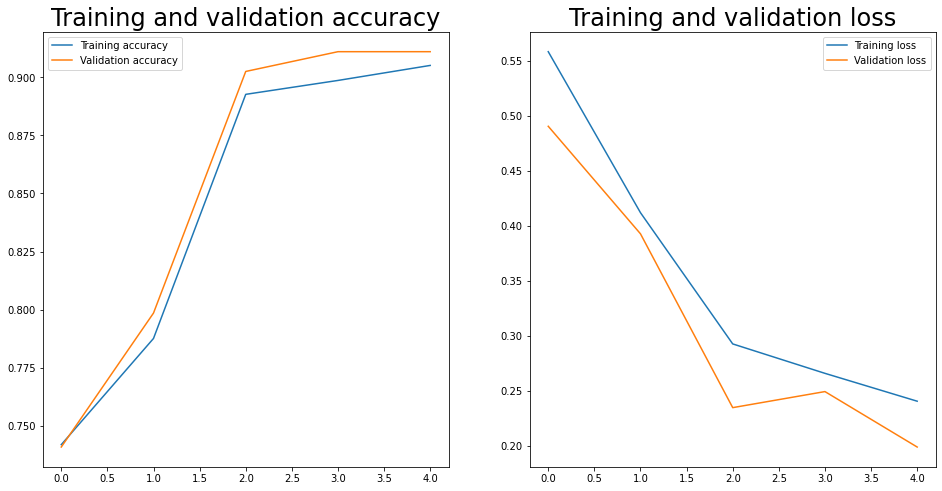

In [14]:
nt_acc = nt_history.history['binary_accuracy']
nt_val_acc = nt_history.history['val_binary_accuracy']
nt_loss = nt_history.history['loss']
nt_val_loss = nt_history.history['val_loss']
nt_epochs = range(len(nt_acc))

nt_fig,nt_ax = plt.subplots(1,2,figsize=(16,8))
nt_ax[0].plot(nt_epochs, nt_acc, label='Training accuracy');
nt_ax[0].plot(nt_epochs, nt_val_acc, label='Validation accuracy');
nt_ax[0].set_title('Training and validation accuracy',fontsize=24);
nt_ax[0].legend();

nt_ax[1].plot(nt_epochs, nt_loss, label='Training loss');
nt_ax[1].plot(nt_epochs, nt_val_loss, label='Validation loss');
nt_ax[1].set_title('Training and validation loss',fontsize=24);
nt_ax[1].legend();

In [15]:
nt_train_results = nt_model.evaluate(train_ds)

131/131 [==============================] - 38s 290ms/step - loss: 0.3081 - binary_accuracy: 0.8889 - precision: 0.8764 - recall: 0.9900


In [16]:
nt_val_res = nt_model.evaluate(val_ds)

34/34 [==============================] - 3s 95ms/step - loss: 0.1988 - binary_accuracy: 0.9111 - precision: 0.9136 - recall: 0.9719


In [17]:
nt_test_res = nt_model.evaluate(test_ds)

20/20 [==============================] - 2s 72ms/step - loss: 0.7167 - binary_accuracy: 0.7949 - precision: 0.7569 - recall: 0.9897


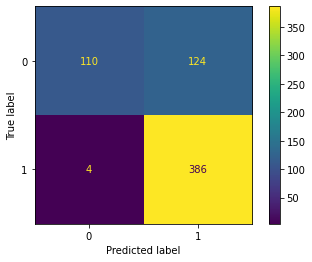

In [18]:
nt_test_predictions = np.round(nt_model.predict(test_ds),0)
test_actual = test_ds.labels
nt_c_matrix = confusion_matrix(test_actual,nt_test_predictions)
ConfusionMatrixDisplay(nt_c_matrix).plot()

<h1>Analysis of Results</h1>

In [19]:
explainer = lime_image.LimeImageExplainer()

<h1>True Positives

In [20]:
def extract_selected(model,true,predicted):
    selected = []
    for batch in range(len(test_ds)):
        for idx,image in enumerate(test_ds[batch][0]):
            if len(selected) >= 6:
                return(selected)
            else:
                if np.round(model.predict(np.expand_dims(image,axis=0)),0) == predicted \
                    and test_ds[batch][1][idx] == true:
                    selected.append(image)
        if len(selected) >= 6:
                return(selected)
    return(selected)

In [21]:
def lime_explain(model,selected_images,title):
    fig,ax = plt.subplots(2,3,figsize=(12,6))
    for idx, image in enumerate(selected_images):
        active_axis = ax[idx//3][idx%3]
        active_axis.set_xticks([])
        active_axis.set_yticks([])
        explanation = explainer.explain_instance(
            image, model.predict, top_labels=1, hide_color=0, num_samples=1000)
        temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=5, hide_rest=False)
        active_axis.imshow(mark_boundaries(temp, mask))
    fig.set_facecolor('#FFFFFF')
    fig.suptitle(title,fontsize=32);
    return(fig)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

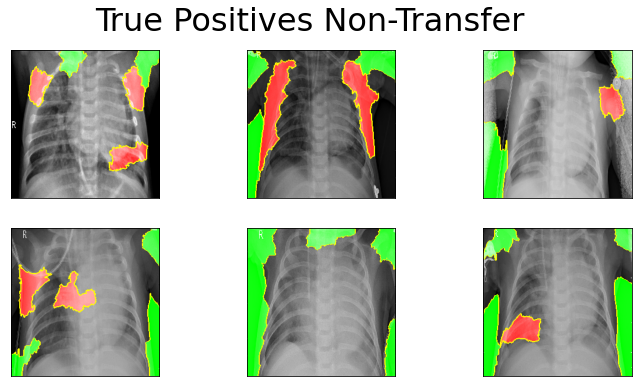

In [22]:
nt_tp = extract_selected(nt_model,1,1)
nt_tp_expl = lime_explain(nt_model,nt_tp,"True Positives Non-Transfer")

<h1>True Negatives

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

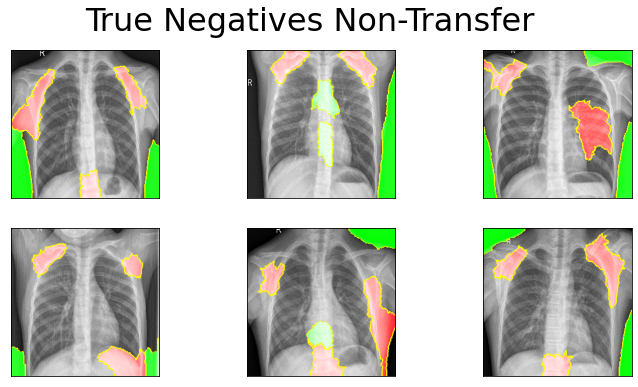

In [23]:
nt_tn = extract_selected(nt_model,0,0)
nt_tn_expl = lime_explain(nt_model,nt_tn,"True Negatives Non-Transfer")

<h1>Fasle Positives

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

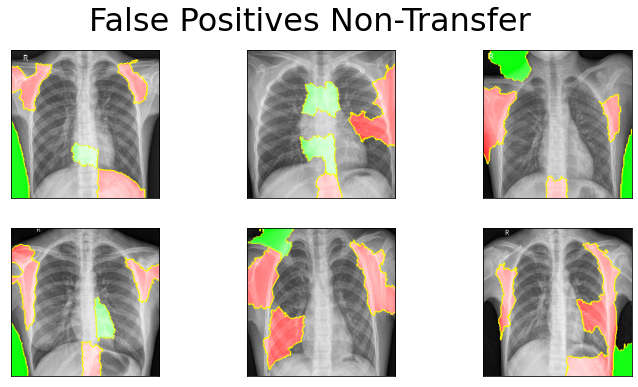

In [24]:
nt_fp = extract_selected(nt_model,0,1)
nt_fp_expl = lime_explain(nt_model,nt_fp,"False Positives Non-Transfer")

<h1>False Negatives

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

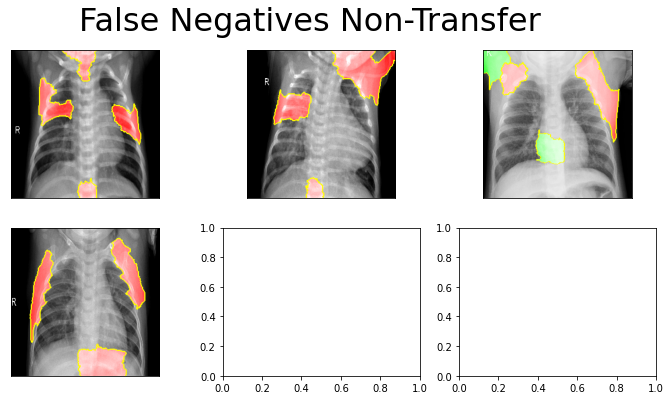

In [25]:
nt_fn = extract_selected(nt_model,1,0)
nt_fn_expl = lime_explain(nt_model,nt_fn,"False Negatives Non-Transfer")

<h1>Intermediate Activations

In [26]:
nt_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      128       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      1056      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      2112      
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      4160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                    

In [27]:
nt_layer_outputs = [layer.output for layer in nt_model.layers[:12]]

activation_model = models.Model(
    inputs = nt_model.input,
    outputs = nt_layer_outputs
)

nt_activations = activation_model.predict(np.expand_dims(test_ds[0][0][0],axis=0))

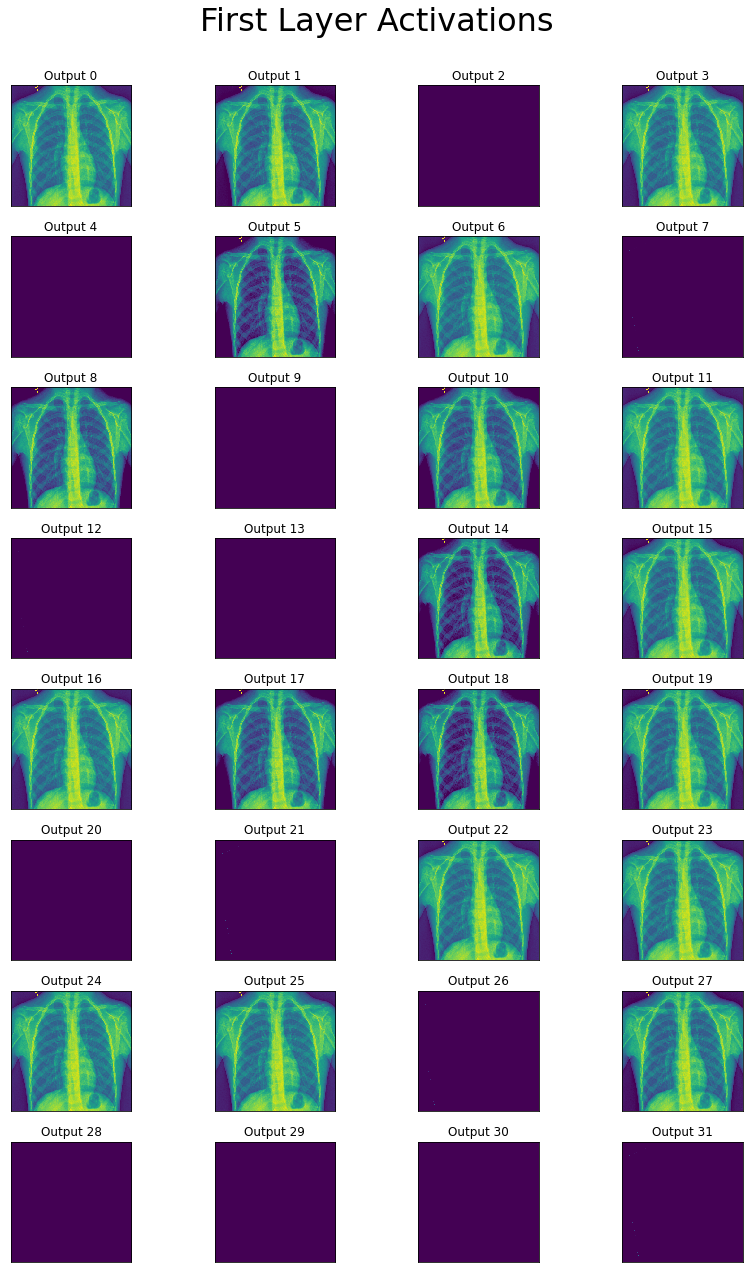

In [28]:
nt_l0_fig, nt_l0_ax = plt.subplots(8, 4, figsize=(12,18))
for idx in range(32):
    active_axis = nt_l0_ax[idx//4, idx%4]
    first_layer_activation = nt_activations[0]
    active_axis.matshow(first_layer_activation[0, :, :, idx])
    active_axis.set_xticks([])
    active_axis.set_yticks([])
    active_axis.set_title('Output ' + str(idx))
nt_l0_fig.set_facecolor('#FFFFFF')
nt_l0_fig.suptitle('First Layer Activations\n',fontsize=32);
nt_l0_fig.tight_layout()

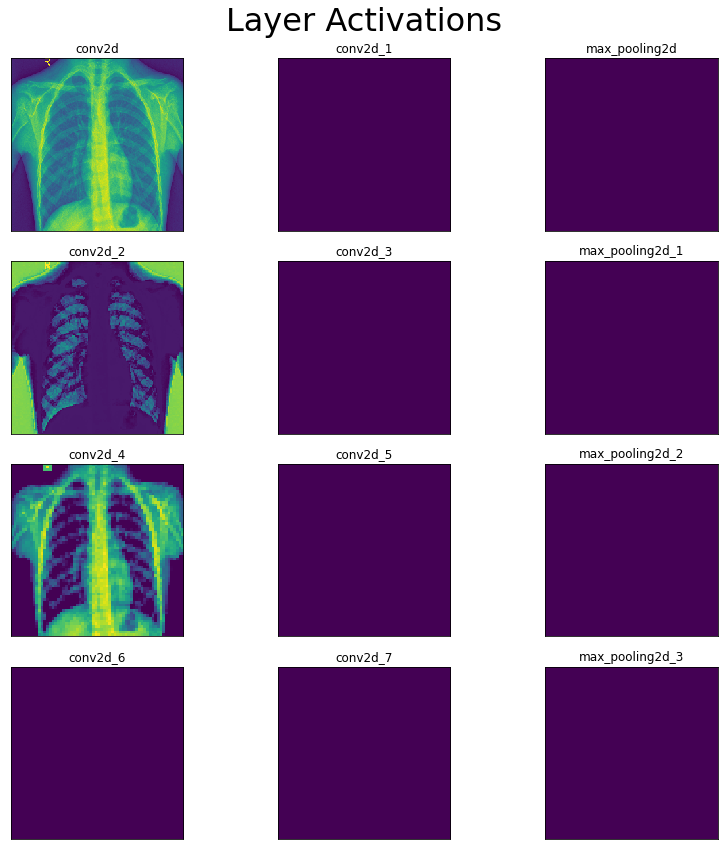

In [29]:
nt_act_fig,nt_act_ax = plt.subplots(4,3,figsize=(12,12))

nt_layer_names = []
for layer in nt_model.layers[:12]:
    nt_layer_names.append(layer.name)

for idx in range(12):
    active_axis = nt_act_ax[idx//3][idx%3]
    cur_layer = nt_activations[idx]
    active_axis.matshow(cur_layer[0,:,:,0])
    active_axis.set_title(nt_layer_names[idx])
    active_axis.set_xticks([])
    active_axis.set_yticks([])
nt_act_fig.set_facecolor('#FFFFFF')
nt_act_fig.suptitle('Layer Activations',fontsize=32);
nt_act_fig.tight_layout()

<h1>Best Model (Transfer Learning with VGG16)

In [30]:
vgg_base = applications.VGG16(
    weights='imagenet',
    input_shape=(256, 256, 3),
    include_top=False
)

vgg_base.trainable = False

In [31]:
tx_model = models.Sequential()

tx_model.add(vgg_base)                   
tx_model.add(layers.Flatten())
tx_model.add(layers.Dense(512, activation='relu'))
tx_model.add(layers.Dense(256, activation='relu'))
tx_model.add(layers.Dense(128, activation='relu'))
tx_model.add(layers.Dense(64, activation='relu'))
tx_model.add(layers.Dense(1, activation='sigmoid'))

for layer in tx_model.layers:
    print(layer.name, layer.trainable)

vgg16 False
flatten_1 True
dense_7 True
dense_8 True
dense_9 True
dense_10 True
dense_11 True


In [32]:
tx_checkpoint = callbacks.ModelCheckpoint(
    monitor='val_loss',
    filepath='save_data/tx_model.hdf5',
    save_best_only=True,
    verbose=0
)

tx_callbacks = [tx_checkpoint]

use_metrics = [metrics.BinaryAccuracy(),\
                metrics.Precision(),\
                metrics.Recall()]

In [33]:
scheduler = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_rate=0.96,
    decay_steps=2500
)

In [34]:
tx_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=scheduler),
    metrics=[use_metrics]
)

print(tx_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_7 (Dense)             (None, 512)               16777728  
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 1)                

In [35]:
with tf.device('/GPU:0'):
    tx_history = tx_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=5,
        callbacks=tx_callbacks
    )

tx_model = models.load_model('save_data/tx_model.hdf5')

Epoch 1/5
131/131 [==============================] - 43s 321ms/step - loss: 0.3363 - binary_accuracy: 0.8695 - precision_1: 0.9057 - recall_1: 0.9200 - val_loss: 0.1614 - val_binary_accuracy: 0.9395 - val_precision_1: 0.9699 - val_recall_1: 0.9476
Epoch 2/5
131/131 [==============================] - 42s 318ms/step - loss: 0.1884 - binary_accuracy: 0.9238 - precision_1: 0.9505 - recall_1: 0.9468 - val_loss: 0.4816 - val_binary_accuracy: 0.7919 - val_precision_1: 1.0000 - val_recall_1: 0.7190
Epoch 3/5
131/131 [==============================] - 42s 318ms/step - loss: 0.1556 - binary_accuracy: 0.9408 - precision_1: 0.9612 - recall_1: 0.9590 - val_loss: 0.1416 - val_binary_accuracy: 0.9442 - val_precision_1: 0.9932 - val_recall_1: 0.9310
Epoch 4/5
131/131 [==============================] - 42s 319ms/step - loss: 0.1567 - binary_accuracy: 0.9349 - precision_1: 0.9561 - recall_1: 0.9561 - val_loss: 0.5778 - val_binary_accuracy: 0.7379 - val_precision_1: 1.0000 - val_recall_1: 0.6462
Epoch 5/

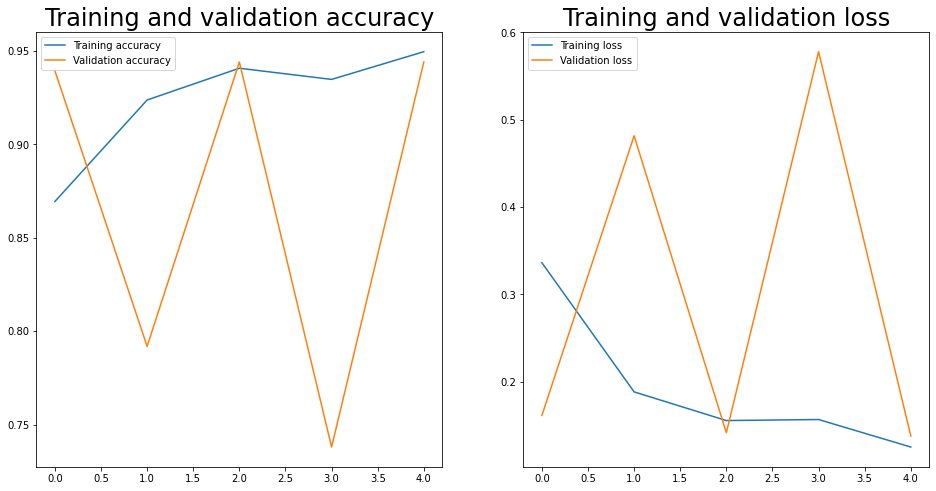

In [36]:
tx_acc = tx_history.history['binary_accuracy']
tx_val_acc = tx_history.history['val_binary_accuracy']
tx_loss = tx_history.history['loss']
tx_val_loss = tx_history.history['val_loss']
tx_epochs = range(len(tx_acc))

tx_fig,tx_ax = plt.subplots(1,2,figsize=(16,8))
tx_ax[0].plot(tx_epochs, tx_acc, label='Training accuracy');
tx_ax[0].plot(tx_epochs, tx_val_acc, label='Validation accuracy');
tx_ax[0].set_title('Training and validation accuracy',fontsize=24);
tx_ax[0].legend();

tx_ax[1].plot(tx_epochs, tx_loss, label='Training loss');
tx_ax[1].plot(tx_epochs, tx_val_loss, label='Validation loss');
tx_ax[1].set_title('Training and validation loss',fontsize=24);
tx_ax[1].legend();

In [37]:
tx_train_res = tx_model.evaluate(train_ds)

131/131 [==============================] - 38s 291ms/step - loss: 0.1143 - binary_accuracy: 0.9576 - precision_1: 0.9543 - recall_1: 0.9903


In [38]:
tx_val_res = tx_model.evaluate(val_ds)

34/34 [==============================] - 4s 101ms/step - loss: 0.1378 - binary_accuracy: 0.9442 - precision_1: 0.9932 - recall_1: 0.9310


In [39]:
tx_test_res = tx_model.evaluate(test_ds)

20/20 [==============================] - 2s 83ms/step - loss: 0.2755 - binary_accuracy: 0.9071 - precision_1: 0.8756 - recall_1: 0.9923


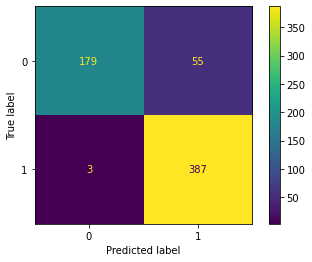

In [40]:
tx_test_predictions = np.round(tx_model.predict(test_ds),0)
test_actual = test_ds.labels
tx_c_matrix = confusion_matrix(test_actual,tx_test_predictions)
ConfusionMatrixDisplay(tx_c_matrix).plot()

<h1>Analysis of Results</h1>

In [41]:
explainer = lime_image.LimeImageExplainer()

<h1>True Positives

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

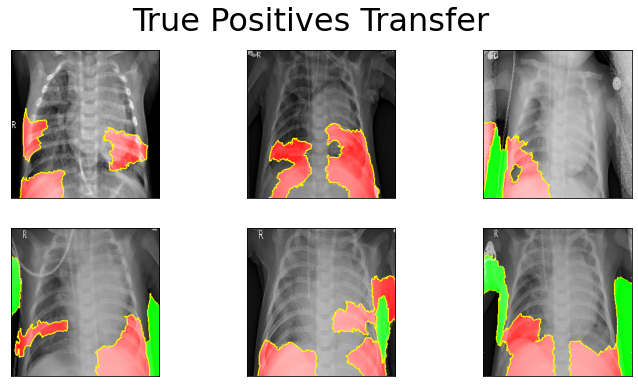

In [42]:
tx_tp = extract_selected(tx_model,1,1)
tx_tp_expl = lime_explain(tx_model,tx_tp,"True Positives Transfer")

<h1>True Negatives

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

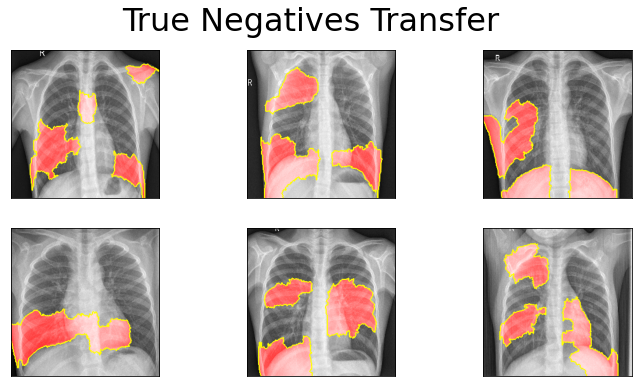

In [43]:
tx_tn = extract_selected(tx_model,0,0)
tx_tn_expl = lime_explain(tx_model,tx_tn,"True Negatives Transfer")

<h1>Fasle Positives

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

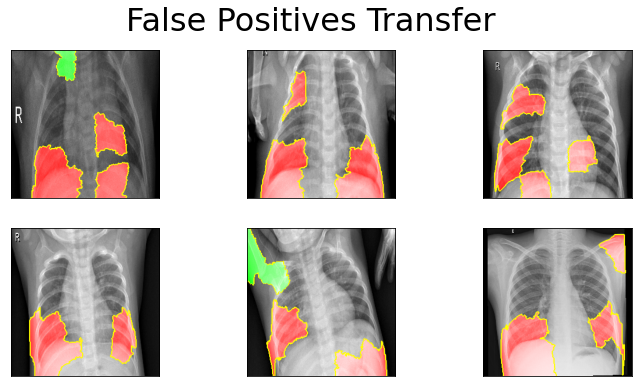

In [44]:
tx_fp = extract_selected(tx_model,0,1)
tx_fp_expl = lime_explain(tx_model,tx_fp,"False Positives Transfer")

<h1>False Negatives

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

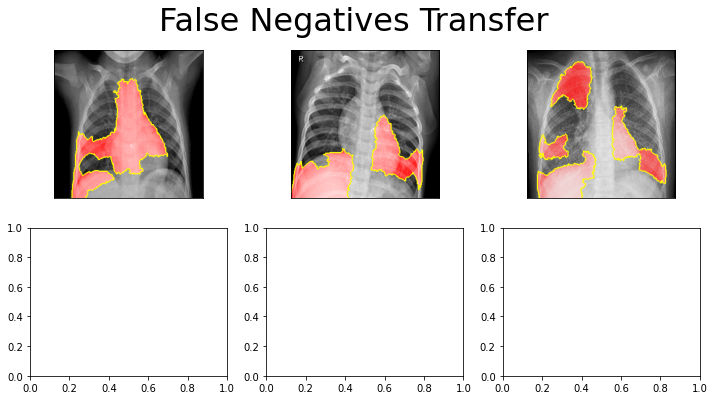

In [45]:
tx_fn = extract_selected(tx_model,1,0)
tx_fn_expl = lime_explain(tx_model,tx_fn,"False Negatives Transfer")

<h1>Intermediate Activations

In [46]:
tx_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_7 (Dense)             (None, 512)               16777728  
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 1)                

In [47]:
tx_model.layers[0].summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [48]:
tx_layer_outputs = [layer.output for layer in tx_model.layers[0].layers]

tx_activation_model = models.Model(
    inputs = tx_model.layers[0].input,
    outputs = tx_layer_outputs
)

activations = tx_activation_model.predict(np.expand_dims(test_ds[0][0][0],axis=0))

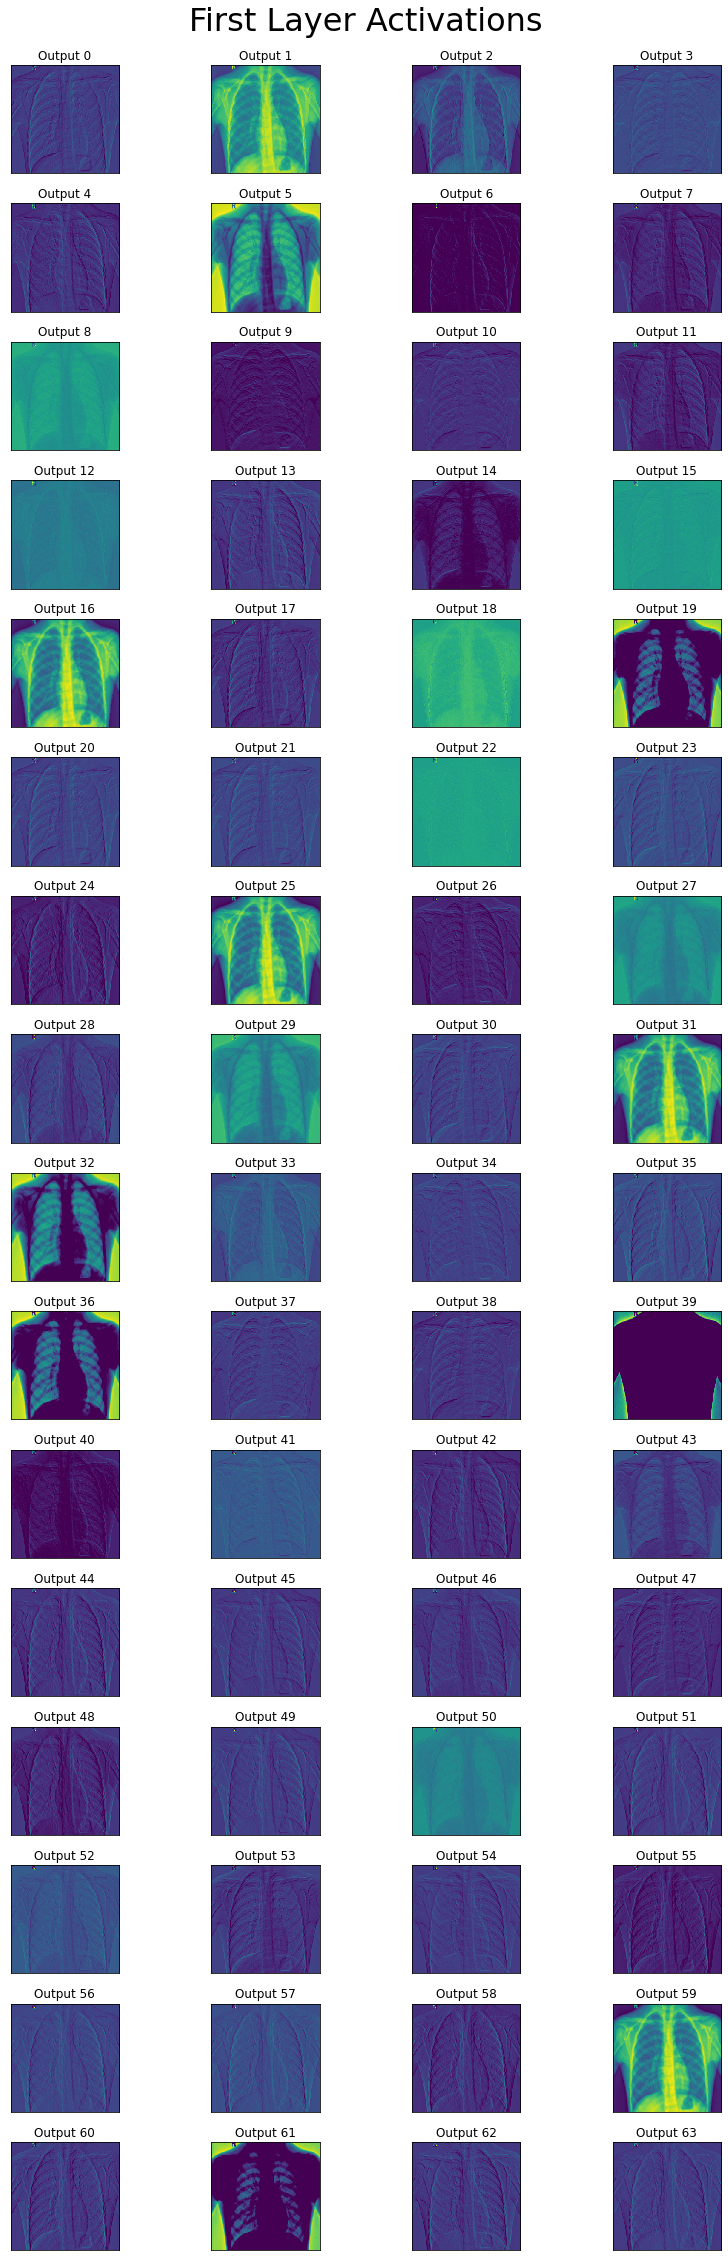

In [49]:
tx_l0_fig, tx_l0_ax = plt.subplots(16, 4, figsize=(12,32))
for idx in range(64):
    active_axis = tx_l0_ax[idx//4, idx%4]
    first_layer_activation = activations[1]
    active_axis.matshow(first_layer_activation[0 , :, :, idx])
    active_axis.set_xticks([])
    active_axis.set_yticks([])
    active_axis.set_title('Output ' + str(idx))
tx_l0_fig.set_facecolor('#FFFFFF')
tx_l0_fig.suptitle('First Layer Activations\n',fontsize=32);
tx_l0_fig.tight_layout()

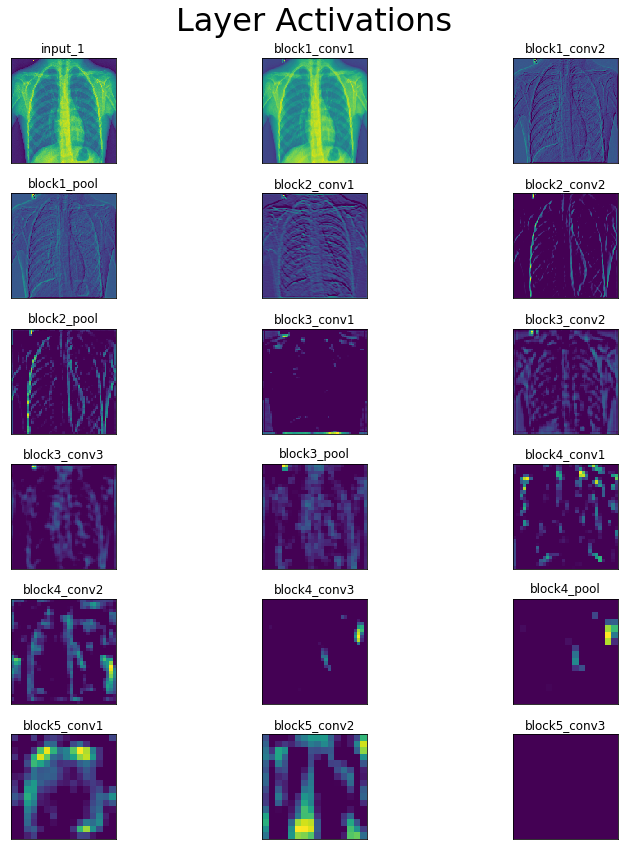

In [50]:
tx_act_fig,tx_act_ax = plt.subplots(6,3,figsize=(12,12))

tx_layer_names = []
for layer in tx_model.layers[0].layers:
    tx_layer_names.append(layer.name)

for idx in range(18):
    active_axis = tx_act_ax[idx//3][idx%3]
    cur_layer = activations[idx]
    active_axis.matshow(cur_layer[0,:,:,1])
    active_axis.set_title(tx_layer_names[idx])
    active_axis.set_xticks([])
    active_axis.set_yticks([])
tx_act_fig.set_facecolor('#FFFFFF')
tx_act_fig.suptitle('Layer Activations',fontsize=32);
tx_act_fig.tight_layout()